### importing libraries

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import os

### Loading data

In [5]:
# Load the analyst ratings dataset
analyst_ratings = pd.read_csv('../data/raw_analyst_ratings.csv')

# Load historical stock data
aapl_data = pd.read_csv('../data/AAPL_historical_data.csv')
amzn_data = pd.read_csv('../data/AMZN_historical_data.csv')
goog_data = pd.read_csv('../data/GOOG_historical_data.csv')
meta_data = pd.read_csv('../data/META_historical_data.csv')
msft_data = pd.read_csv('../data/MSFT_historical_data.csv')
nvda_data = pd.read_csv('../data/NVDA_historical_data.csv')
tsla_data = pd.read_csv('../data/TSLA_historical_data.csv')

### Data Preparation
#### Normalize Dates

In [6]:
analyst_ratings['date'] = pd.to_datetime(analyst_ratings['date'], format='ISO8601', utc=True).dt.normalize()

In [7]:
analyst_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407328 entries, 0 to 1407327
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype              
---  ------      --------------    -----              
 0   Unnamed: 0  1407328 non-null  int64              
 1   headline    1407328 non-null  object             
 2   url         1407328 non-null  object             
 3   publisher   1407328 non-null  object             
 4   date        1407328 non-null  datetime64[ns, UTC]
 5   stock       1407328 non-null  object             
dtypes: datetime64[ns, UTC](1), int64(1), object(4)
memory usage: 64.4+ MB


In [8]:
aapl_data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Dividends', 'Stock Splits'],
      dtype='object')

In [9]:
# Convert dates to ensure datasets are aligned
aapl_data['Date'] = pd.to_datetime(aapl_data['Date'], format='ISO8601', utc=True).dt.normalize()
amzn_data['Date'] = pd.to_datetime(amzn_data['Date'], format='ISO8601', utc=True).dt.normalize()
goog_data['Date'] = pd.to_datetime(goog_data['Date'], format='ISO8601', utc=True).dt.normalize()
meta_data['Date'] = pd.to_datetime(meta_data['Date'], format='ISO8601', utc=True).dt.normalize()
msft_data['Date'] = pd.to_datetime(msft_data['Date'], format='ISO8601', utc=True).dt.normalize()
nvda_data['Date'] = pd.to_datetime(nvda_data['Date'], format='ISO8601', utc=True).dt.normalize()
tsla_data['Date'] = pd.to_datetime(aapl_data['Date'], format='ISO8601', utc=True).dt.normalize()

In [10]:
aapl_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10998 entries, 0 to 10997
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   Date          10998 non-null  datetime64[ns, UTC]
 1   Open          10998 non-null  float64            
 2   High          10998 non-null  float64            
 3   Low           10998 non-null  float64            
 4   Close         10998 non-null  float64            
 5   Adj Close     10998 non-null  float64            
 6   Volume        10998 non-null  int64              
 7   Dividends     10998 non-null  float64            
 8   Stock Splits  10998 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(7), int64(1)
memory usage: 773.4 KB


In [11]:
# converting 'Date' to column to 'date' to have the same column name with analyst_ratings
aapl_data.rename(columns={'Date': 'date'}, inplace=True)
amzn_data.rename(columns={'Date': 'date'}, inplace=True)
goog_data.rename(columns={'Date': 'date'}, inplace=True)
meta_data.rename(columns={'Date': 'date'}, inplace=True)
msft_data.rename(columns={'Date': 'date'}, inplace=True)
nvda_data.rename(columns={'Date': 'date'}, inplace=True)
tsla_data.rename(columns={'Date': 'date'}, inplace=True)

In [12]:
# Merge datasets on the date
merged_data_1 = pd.merge(analyst_ratings, aapl_data, on='date', how='inner')
merged_data_2 = pd.merge(analyst_ratings, amzn_data, on='date', how='inner')
merged_data_3 = pd.merge(analyst_ratings, goog_data, on='date', how='inner')
merged_data_4 = pd.merge(analyst_ratings, meta_data, on='date', how='inner')
merged_data_5 = pd.merge(analyst_ratings, msft_data, on='date', how='inner')
merged_data_6 = pd.merge(analyst_ratings, nvda_data, on='date', how='inner')
merged_data_7 = pd.merge(analyst_ratings, tsla_data, on='date', how='inner')

In [13]:
merged_data_1.head()

,Unnamed: 0,headline,url,publisher,date,stock,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 00:00:00+00:00,A,80.837502,82.937500,80.807503,82.875000,80.843407,137250400,0.0,0.0
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 00:00:00+00:00,A,81.165001,81.550003,80.574997,81.279999,79.287506,104491200,0.0,0.0
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 00:00:00+00:00,A,80.875000,81.059998,79.125000,79.182503,77.241432,125522000,0.0,0.0
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 00:00:00+00:00,A,78.942497,79.807503,78.837502,79.722504,77.768188,81803200,0.0,0.0
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 00:00:00+00:00,A,78.942497,79.807503,78.837502,79.722504,77.768188,81803200,0.0,0.0


# Sentiment Analysis

In [14]:
# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Apply sentiment analysis to headlines
analyst_ratings['sentiment'] = analyst_ratings['headline'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Classify sentiment based on compound score
def classify_sentiment(compound_score):
    if compound_score >= 0.05:
        return 'positive'
    elif compound_score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

analyst_ratings['sentiment_class'] = analyst_ratings['sentiment'].apply(classify_sentiment)


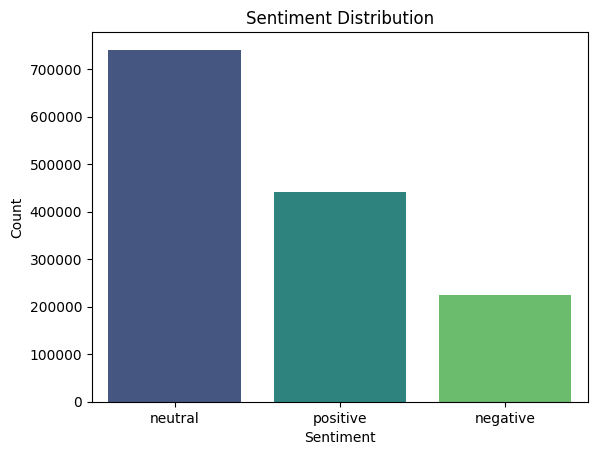

In [15]:
sns.countplot(x='sentiment_class', data=analyst_ratings, hue='sentiment_class', palette='viridis', legend=False)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Calculate Stock Movements
## Compute Daily Returns

In [16]:
aapl_data['daily_return'] = aapl_data['Close'].pct_change() * 100
amzn_data['daily_return'] = amzn_data['Close'].pct_change() * 100
goog_data['daily_return'] = goog_data['Close'].pct_change() * 100
meta_data['daily_return'] = meta_data['Close'].pct_change() * 100
msft_data['daily_return'] = msft_data['Close'].pct_change() * 100
nvda_data['daily_return'] = nvda_data['Close'].pct_change() * 100
tsla_data['daily_return'] = tsla_data['Close'].pct_change() * 100

## Correlation Analysis
### Aggregate Daily Sentiment

In [17]:
daily_sentiment = analyst_ratings.groupby('date')['sentiment'].mean().reset_index()

### Calculate Correlation

In [18]:
merged_data_aapl = pd.merge(daily_sentiment, aapl_data[['date', 'daily_return']], on='date')
merged_data_amzn = pd.merge(daily_sentiment, amzn_data[['date', 'daily_return']], on='date')
merged_data_goog = pd.merge(daily_sentiment, goog_data[['date', 'daily_return']], on='date')
merged_data_meta = pd.merge(daily_sentiment, meta_data[['date', 'daily_return']], on='date')
merged_data_msft = pd.merge(daily_sentiment, msft_data[['date', 'daily_return']], on='date')
merged_data_nvda = pd.merge(daily_sentiment, nvda_data[['date', 'daily_return']], on='date')
merged_data_tsla = pd.merge(daily_sentiment, tsla_data[['date', 'daily_return']], on='date')

In [19]:
correlation_aapl = merged_data_aapl['sentiment'].corr(merged_data_aapl['daily_return'])
print(f"Pearson correlation coefficient: {correlation_aapl}")

Pearson correlation coefficient: 0.14605816008631775


In [20]:
correlation_amzn = merged_data_amzn['sentiment'].corr(merged_data_amzn['daily_return'])
print(f"Pearson correlation coefficient: {correlation_amzn}")

Pearson correlation coefficient: 0.08223958354879742


In [21]:
correlation_goog = merged_data_goog['sentiment'].corr(merged_data_goog['daily_return'])
print(f"Pearson correlation coefficient: {correlation_goog}")

Pearson correlation coefficient: 0.1254442076452607


In [22]:
correlation_meta = merged_data_meta['sentiment'].corr(merged_data_meta['daily_return'])
print(f"Pearson correlation coefficient: {correlation_meta}")

Pearson correlation coefficient: 0.16399365746755015


In [23]:
correlation_msft = merged_data_msft['sentiment'].corr(merged_data_msft['daily_return'])
print(f"Pearson correlation coefficient: {correlation_msft}")

Pearson correlation coefficient: 0.12222555062309494


In [24]:
correlation_nvda = merged_data_nvda['sentiment'].corr(merged_data_nvda['daily_return'])
print(f"Pearson correlation coefficient: {correlation_nvda}")

Pearson correlation coefficient: 0.11459758587437814


In [25]:
correlation_tsla = merged_data_tsla['sentiment'].corr(merged_data_tsla['daily_return'])
print(f"Pearson correlation coefficient: {correlation_tsla}")

Pearson correlation coefficient: nan


In [26]:
print(analyst_ratings['date'].min(), analyst_ratings['date'].max())
print(tsla_data['date'].min(), tsla_data['date'].max())

2009-02-14 00:00:00+00:00 2020-06-11 00:00:00+00:00
1980-12-12 00:00:00+00:00 1994-12-19 00:00:00+00:00


as seen from the output they have date time range difference b/n them. this is the reason why correlation for tsla become nan

## visualization

### Time Series Plot: Sentiment vs. Daily Return

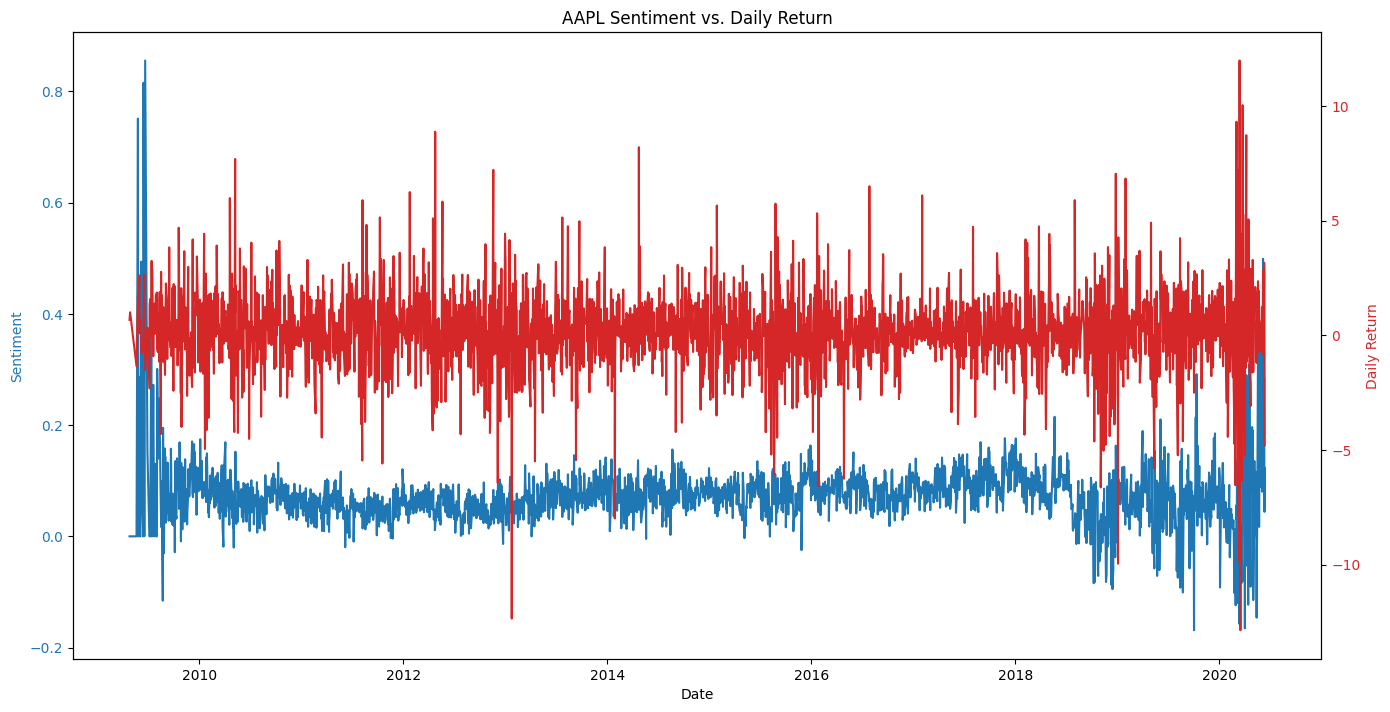

In [27]:
# Example for AAPL
fig, ax1 = plt.subplots(figsize=(14, 7))

ax1.set_xlabel('Date')
ax1.set_ylabel('Sentiment', color='tab:blue')
ax1.plot(merged_data_aapl['date'], merged_data_aapl['sentiment'], color='tab:blue', label='Sentiment')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Daily Return', color='tab:red')
ax2.plot(merged_data_aapl['date'], merged_data_aapl['daily_return'], color='tab:red', label='Daily Return')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.title('AAPL Sentiment vs. Daily Return')
plt.show()

### Scatter Plot: Sentiment vs. Daily Returns

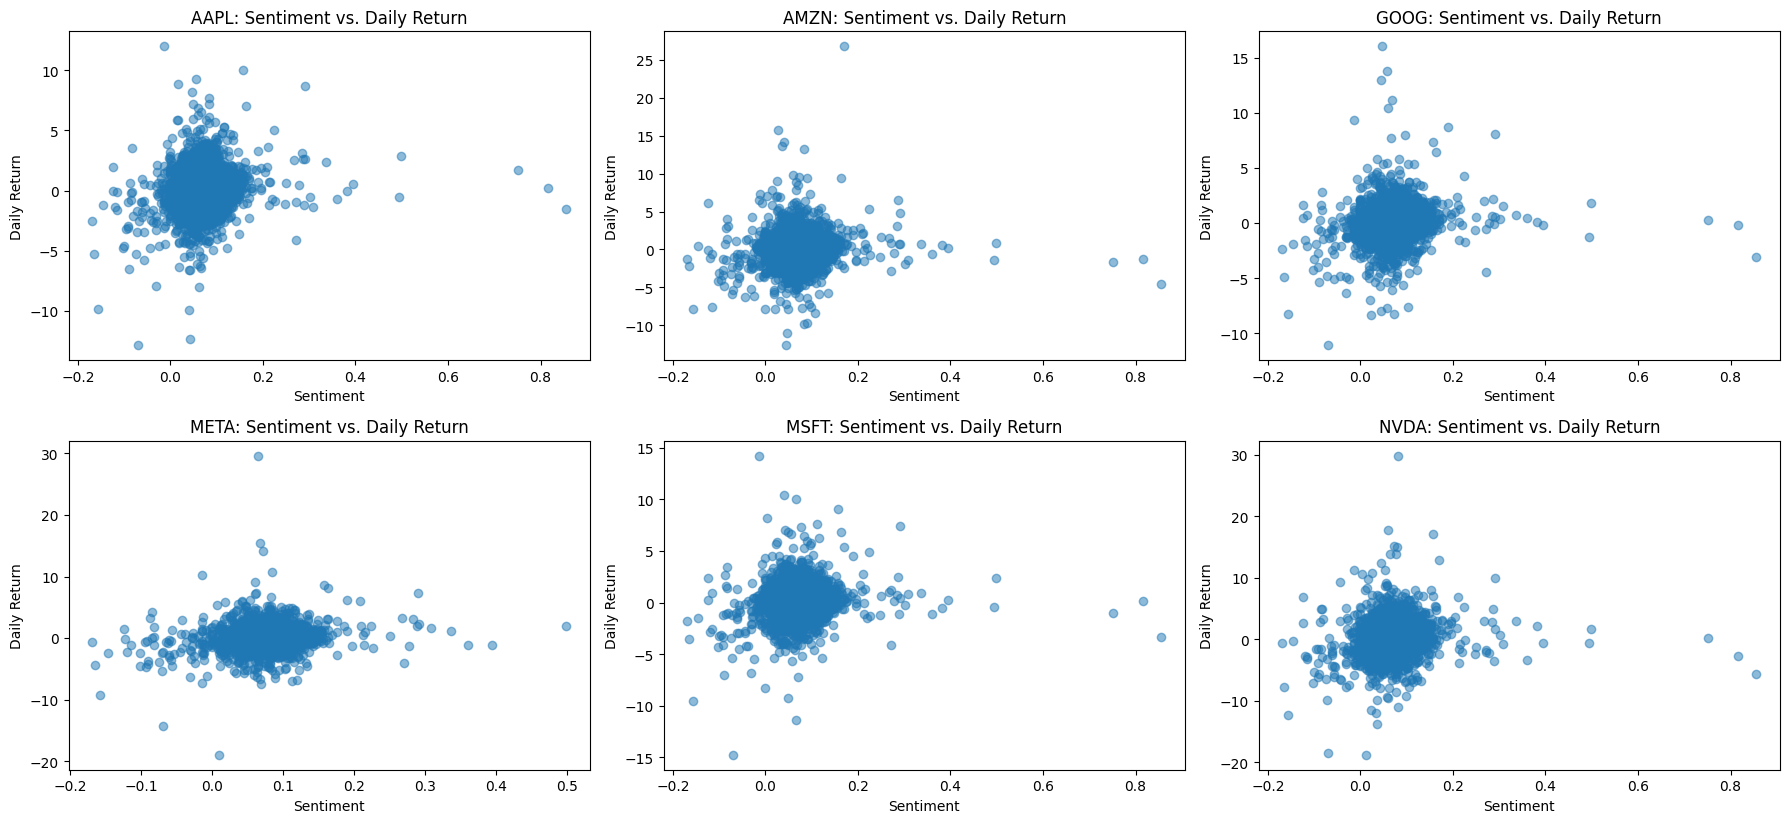

In [28]:
# Create a list of your merged datasets
merged_datasets = [
    ('AAPL', merged_data_aapl),
    ('AMZN', merged_data_amzn),
    ('GOOG', merged_data_goog),
    ('META', merged_data_meta),
    ('MSFT', merged_data_msft),
    ('NVDA', merged_data_nvda),
]

# Set up the figure and axes for subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))
axes = axes.flatten()

# Loop through each dataset and plot
for i, (ticker, data) in enumerate(merged_datasets):
    axes[i].scatter(data['sentiment'], data['daily_return'], alpha=0.5)
    axes[i].set_title(f'{ticker}: Sentiment vs. Daily Return')
    axes[i].set_xlabel('Sentiment')
    axes[i].set_ylabel('Daily Return')

# Remove any empty subplots (if there are less than 9 stocks)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### Correlation Heatmap

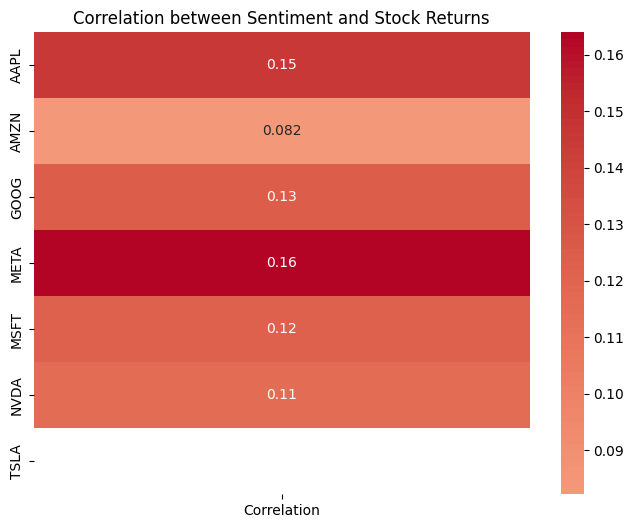

In [29]:
# Collect correlations
correlations = {
    'AAPL': correlation_aapl,
    'AMZN': correlation_amzn,
    'GOOG': correlation_goog,
    'META': correlation_meta,
    'MSFT': correlation_msft,
    'NVDA': correlation_nvda,
    'TSLA': correlation_tsla
}

# Convert to DataFrame for heatmap
corr_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['Correlation'])

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between Sentiment and Stock Returns')
plt.show()

### Moving Average of Sentiment vs. Stock Prices

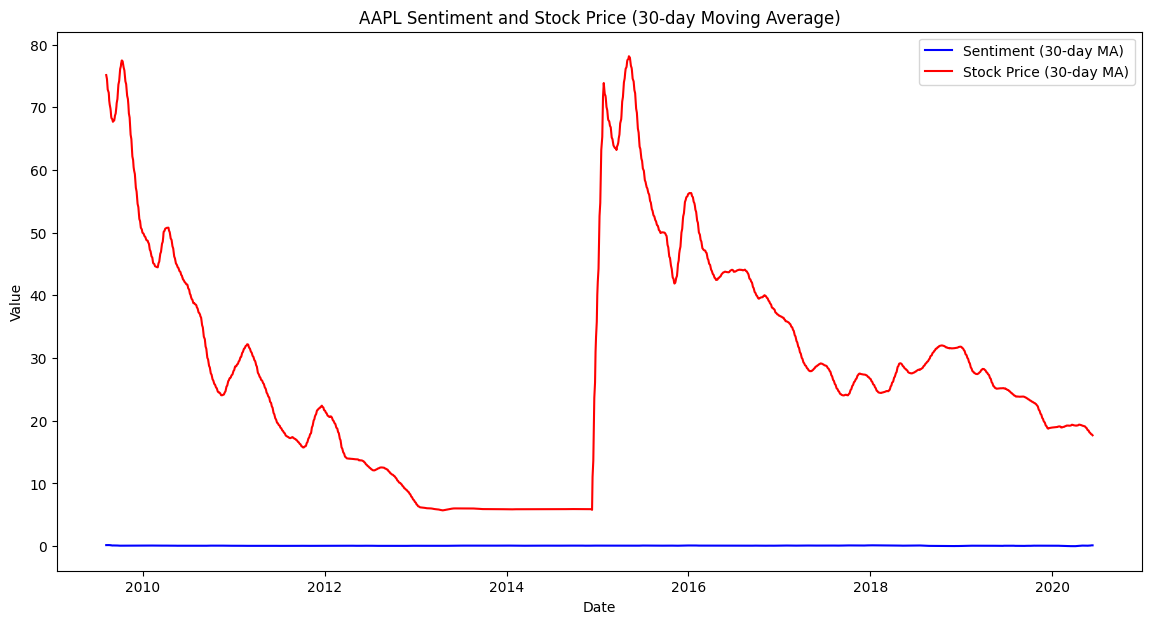

In [30]:
# for AAPL with a 30-day moving average
merged_data_aapl['sentiment_ma'] = merged_data_aapl['sentiment'].rolling(window=30).mean()
merged_data_aapl['price_ma'] = merged_data_1['Close'].rolling(window=30).mean()

plt.figure(figsize=(14, 7))
plt.plot(merged_data_aapl['date'], merged_data_aapl['sentiment_ma'], label='Sentiment (30-day MA)', color='blue')
plt.plot(merged_data_aapl['date'], merged_data_aapl['price_ma'], label='Stock Price (30-day MA)', color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('AAPL Sentiment and Stock Price (30-day Moving Average)')
plt.legend()
plt.show()

#### correlation plot

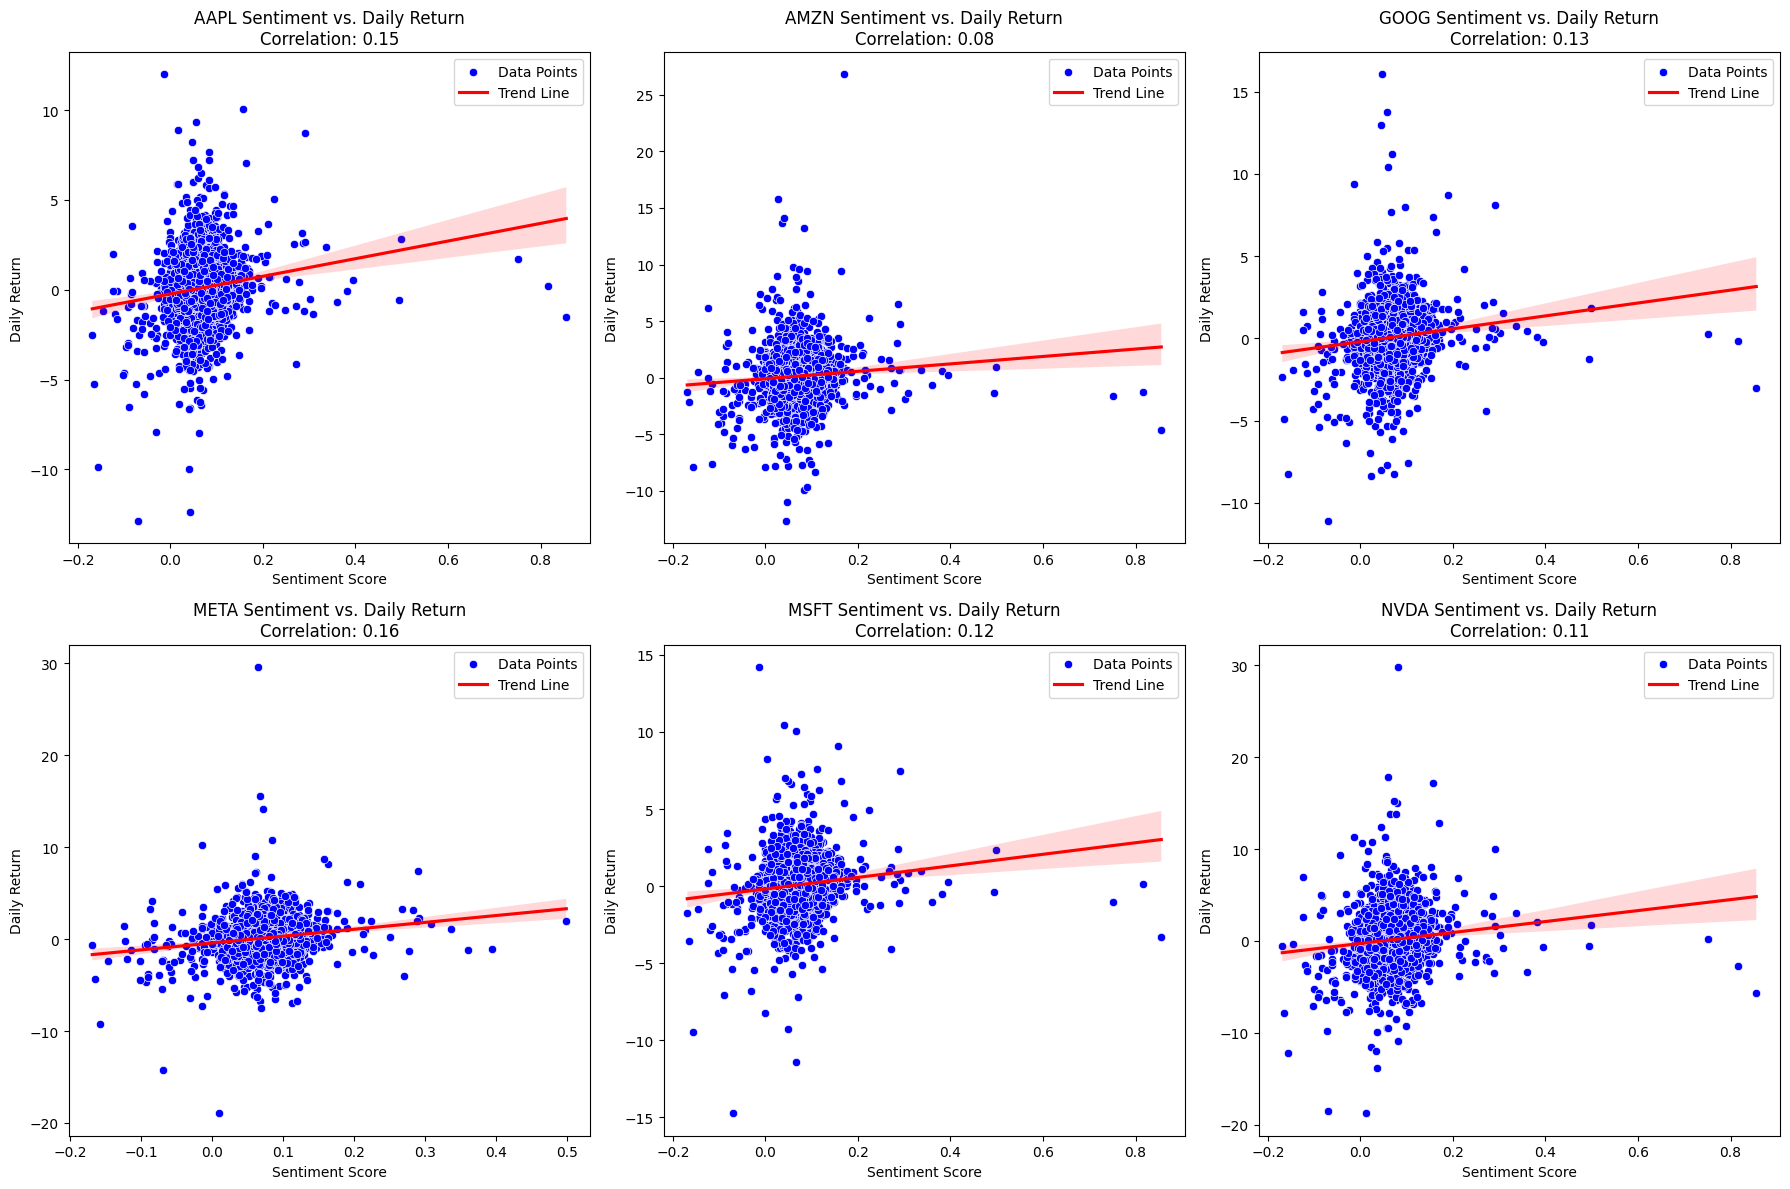

In [31]:
# List of datasets and labels
datasets = [
    (merged_data_aapl, 'AAPL', correlation_aapl),
    (merged_data_amzn, 'AMZN', correlation_amzn),
    (merged_data_goog, 'GOOG', correlation_goog),
    (merged_data_meta, 'META', correlation_meta),
    (merged_data_msft, 'MSFT', correlation_msft),
    (merged_data_nvda, 'NVDA', correlation_nvda),
]

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for i, (data, stock, correlation) in enumerate(datasets):
    ax = axes[i//3, i%3]
    sns.scatterplot(x=data['sentiment'], y=data['daily_return'], ax=ax, color='blue', label='Data Points')
    sns.regplot(x=data['sentiment'], y=data['daily_return'], scatter=False, ax=ax, color='red', label='Trend Line')
    ax.set_title(f'{stock} Sentiment vs. Daily Return\nCorrelation: {correlation:.2f}')
    ax.set_xlabel('Sentiment Score')
    ax.set_ylabel('Daily Return')
    ax.legend()

plt.tight_layout()
plt.show()